In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as img
import panel as pn
import itertools
import math

pn.extension()

In [2]:
image_dir = Path("../images")
files = list(image_dir.rglob("*.png"))
files[10:13]

[PosixPath('../images/SiO3+0002-03-16 12:00:00+z_t@500.0.png'),
 PosixPath('../images/SiO3+0004-01-16 12:00:00+log_10@True+z_t@500.0.png'),
 PosixPath('../images/PO4+0001-02-15 00:00:00+z_t@35109.34765625.png')]

In [3]:
entries = []
for file in files:
    path = file.as_posix()
    if "checkpoint" in path:
        print(path)
        continue
    parts = file.stem.split("+")
    x = dict(varname=parts[0], time=parts[1], path=path)
    if len(parts) > 2:
        for part in parts[2:]:
            y = part.split("@")
            x[y[0]] = y[1]
            if y[0].startswith("z_t"):
                x["depth_level"] = y[1]
    entries.append(x)

df = pd.DataFrame(entries)

df["z_t"] = df["z_t"].astype(float)
df["z_t_150m"] = df["z_t_150m"].astype(float)
df["depth_level"] = df["depth_level"].astype(float)
df["depth_level"] = df["depth_level"].fillna(-9999)
df["log_10"] = df.log_10.map(lambda x: True if x == "True" else False)


def split_time(x):
    time = x["time"]
    time_components = time.split("-")
    x["year"] = int(time_components[0])
    x["month"] = int(time_components[1])
    return x


def get_image(path):
    data = img.imread(path)
    plt.figure(figsize=(8, 6))
    ax = plt.imshow(data)
    fig = ax.get_figure()
    plt.axis("off")
    plt.close(fig)
    return fig


df = df.apply(split_time, axis=1)


grouped = df.groupby(["varname", "time", "depth_level", "log_10"])
figures = {key: [] for key in grouped.groups.keys()}


def get_group_figures(key, figures=figures):
    if len(figures[key]) == 0:
        figures[key] = [
            get_image(path) for path in grouped.get_group(key).path.tolist()
        ]
    return figures[key]


df.head()

../images/.ipynb_checkpoints/CaCO3_FLUX_100m+0001-01-16 12:15:50-checkpoint.png
../images/.ipynb_checkpoints/spChl+0004-07-16 12:00:00+z_t_150m@500.0-checkpoint.png
../images/.ipynb_checkpoints/CaCO3_FLUX_100m+0001-01-16 12:15:50+log_10@True-checkpoint.png
../images/.ipynb_checkpoints/PO4+0004-01-16 12:00:00+z_t@500.0-checkpoint.png
../images/.ipynb_checkpoints/spChl+0004-02-15 00:00:00+log_10@True+z_t_150m@500.0-checkpoint.png
../images/.ipynb_checkpoints/photoC_cocco_zint+0001-04-16 00:00:00-checkpoint.png
../images/.ipynb_checkpoints/photoC_diaz_zint+0001-01-16 12:15:50-checkpoint.png
../images/.ipynb_checkpoints/O2+0001-08-16 12:00:00+z_t@35109.34765625-checkpoint.png
../images/.ipynb_checkpoints/photoC_diaz_zint+0001-07-16 12:00:00-checkpoint.png


,varname,time,path,z_t_150m,depth_level,log_10,z_t,year,month
0,photoC_cocco_zint,0004-02-15 00:00:00,../images/photoC_cocco_zint+0004-02-15 00:00:0...,NaN,-9999.0,False,NaN,4,2
1,photoC_diat_zint,0002-12-16 12:00:00,../images/photoC_diat_zint+0002-12-16 12:00:00...,NaN,-9999.0,False,NaN,2,12
2,O2_ZMIN_DEPTH,0004-04-16 00:00:00,../images/O2_ZMIN_DEPTH+0004-04-16 00:00:00.png,NaN,-9999.0,False,NaN,4,4
3,diatChl,0002-05-16 12:00:00,../images/diatChl+0002-05-16 12:00:00+z_t_150m...,500.0,500.0,False,NaN,2,5
4,CaCO3_FLUX_100m,0001-08-16 12:00:00,../images/CaCO3_FLUX_100m+0001-08-16 12:00:00+...,NaN,-9999.0,True,NaN,1,8


In [6]:
variables = pn.widgets.CheckBoxGroup(
    name="variable",
    value=["CaCO3_FLUX_100m"],
    options=sorted(list(df.varname.unique())),
)
times = pn.widgets.Select(name="time", options=sorted(list(df.time.unique())))
log_10 = pn.widgets.Checkbox(name="log_10", value=False)
depth_levels = pn.widgets.Select(
    name="depth_level", options=sorted(list(df.depth_level.unique()))
)


@pn.depends(variables, times, depth_levels, log_10)
def viewer(variables, times, depth_levels, log_10):
    keys = list(
        itertools.product(*[variables, [times], [depth_levels], [log_10]])
    )
    images_data = []
    for key in keys:
        try:
            df = grouped.get_group(key)
            path = df.iloc[0].path
            varname = df.iloc[0].varname
            data = img.imread(path)
            images_data.append([varname, data])
        except KeyError:
            pass
    if images_data:
        if len(images_data) < 2:
            nrows = 1
            ncols = 1
        elif len(images_data) < 6:
            ncols = 2
            nrows = math.ceil(len(images_data) / ncols)
        else:
            ncols = 3
            nrows = math.ceil(len(images_data) / ncols)

        fig, axes = plt.subplots(
            nrows=nrows, ncols=ncols, figsize=(16, 10), squeeze=False
        )
        for data, ax in zip(images_data, axes.flat):
            ax.imshow(data[1])
            ax.axis("off")
            ax.set_title(f"{data[0]}")

        empty_subplot_indices = set(range(len(axes.flat))) - set(
            range(len(images_data))
        )
        if empty_subplot_indices:
            for index in empty_subplot_indices:
                fig.delaxes(axes.flatten()[index])
        plt.tight_layout()
        plt.close(fig)
        return fig

Row
    [0] Column(width=400)
        [0] Markdown(str)
        [1] CheckBoxGroup(name='variable', options=['CaCO3_FLUX_100m', ...], value=['CaCO3_FLUX_100m'])
        [2] Checkbox(name='log_10')
        [3] Select(name='time', options=['0001-01-16 12:15:50', ...], value='0001-01-16 12:15:50')
        [4] Select(name='depth_level', options=[-9999.0, 500.0, ...], value=-9999.0)
    [1] Column
        [0] ParamFunction(function)
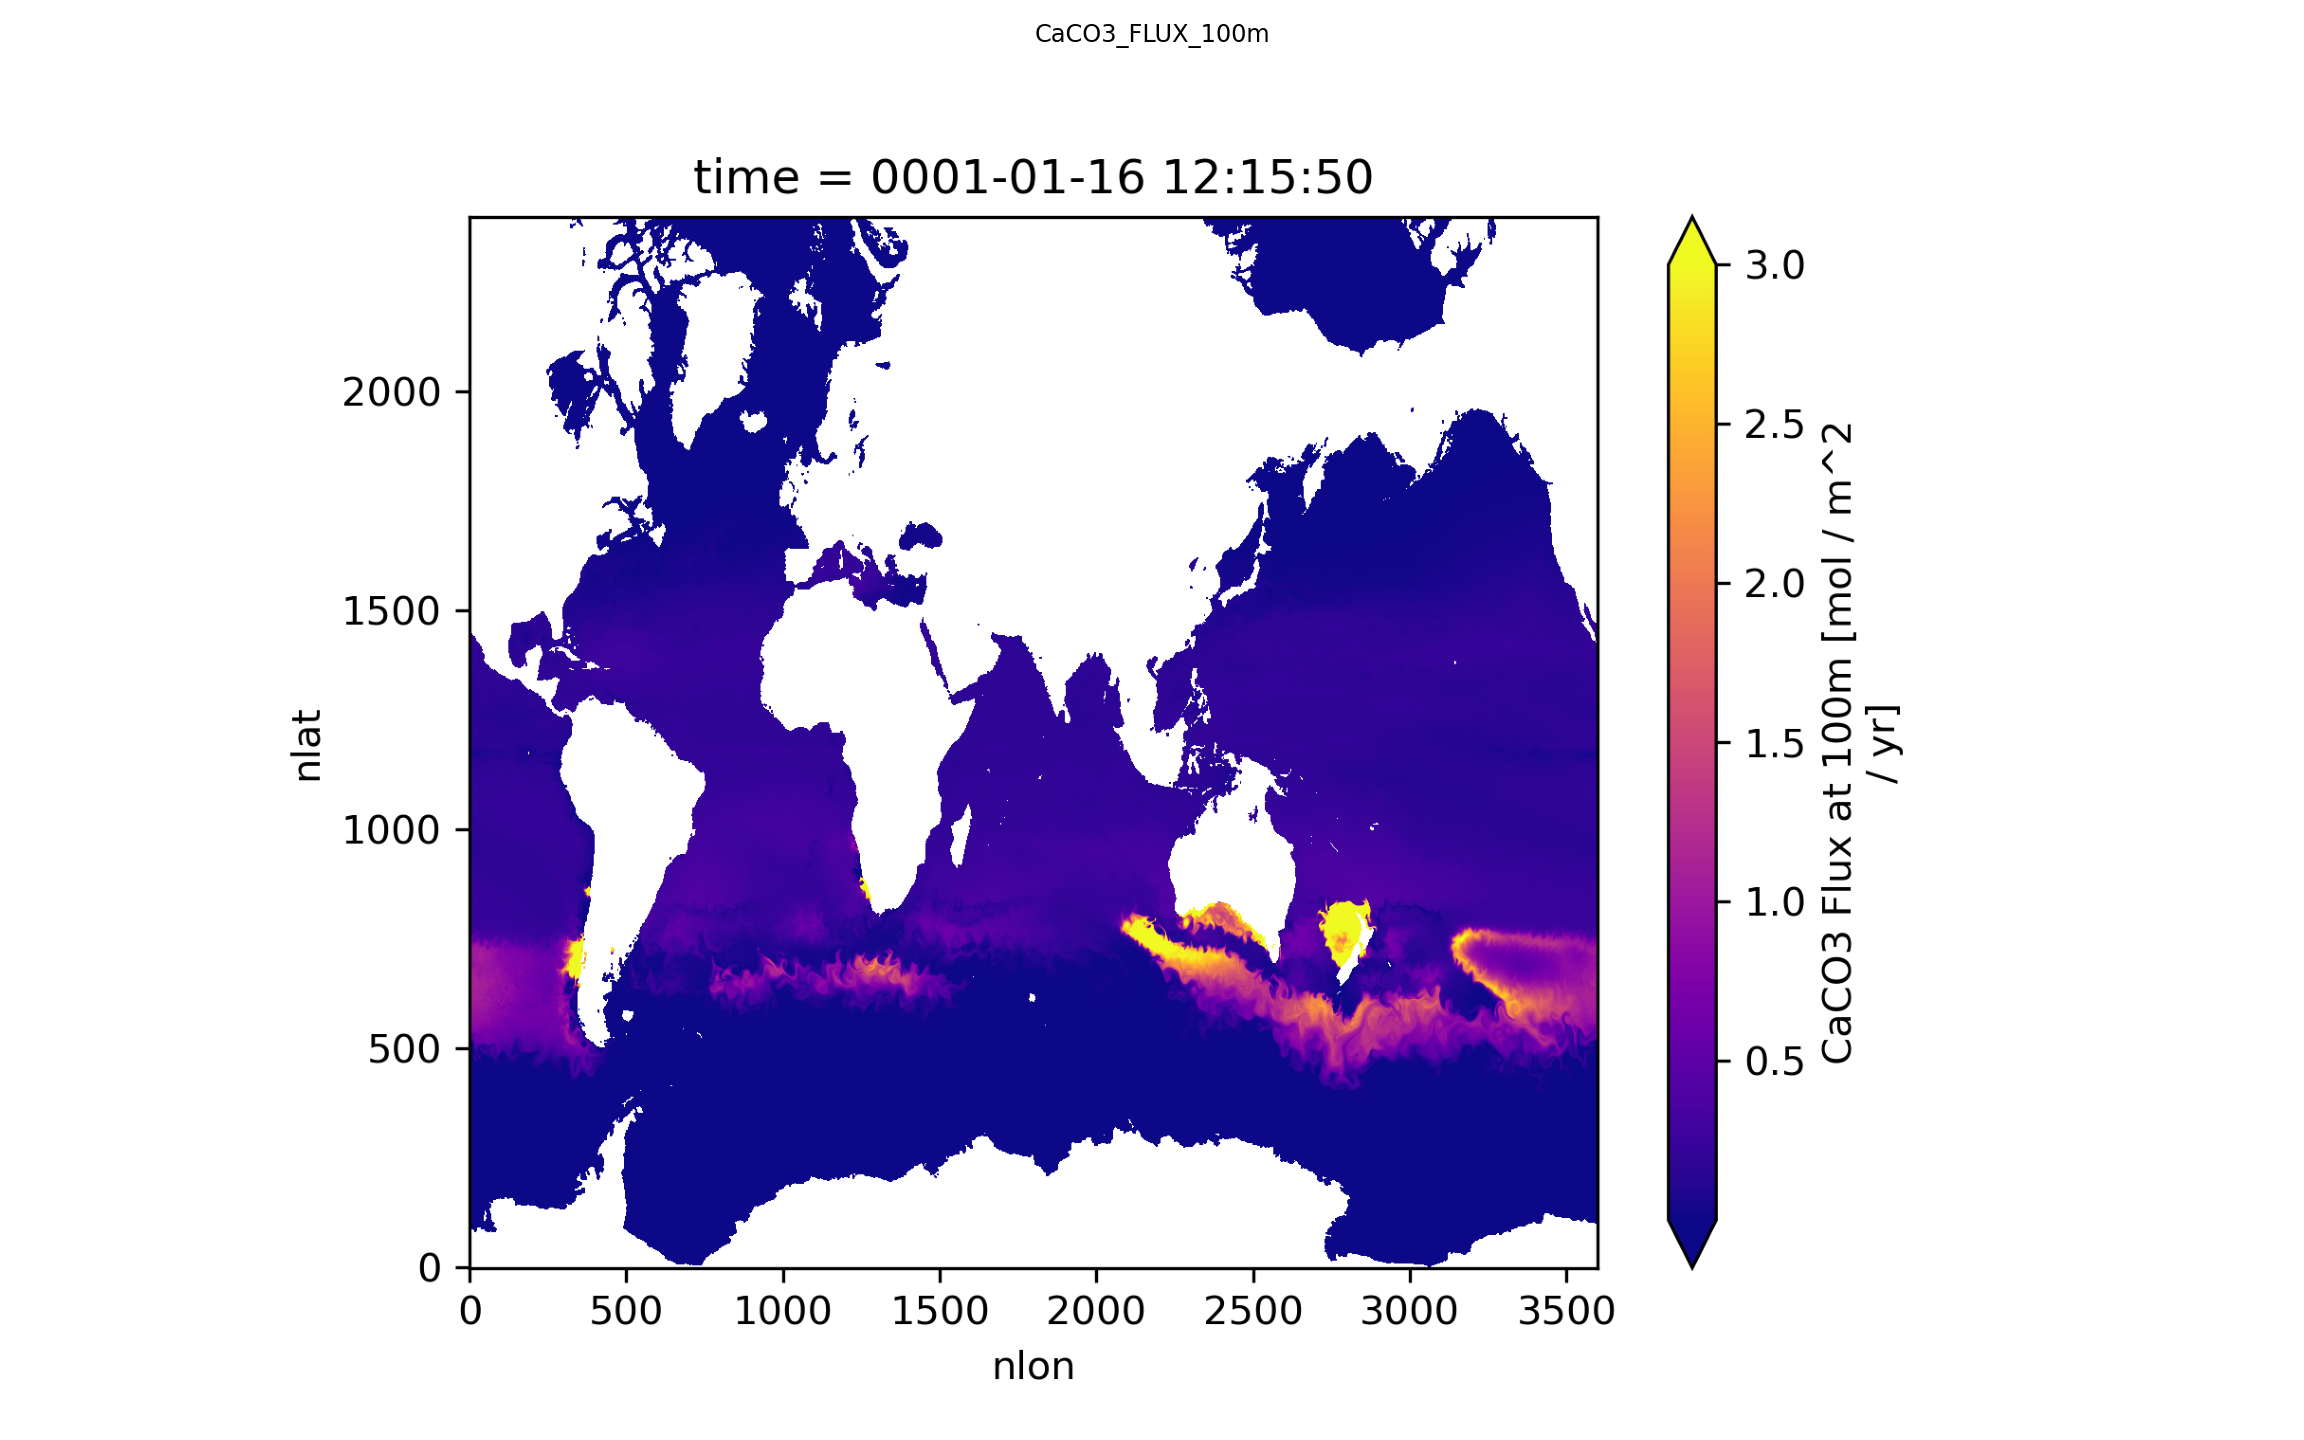

In [7]:
controls = pn.Column(variables, log_10, times, depth_levels)
images = pn.Column(viewer)
v = pn.Row(controls, viewer)
text = "<br>\n# Image Viewer\nSelect variables, depth level, and time step"
p = pn.Row(
    pn.Column(text, v[0][0], v[0][1], v[0][2], v[0][3], width=400),
    pn.Column(v[1][0]),
)
p